In [1]:
import pandas as pd
import os

def get_image_path(image_id:int):
    return os.path.join('../tiles_768', str(image_id))

I_FOLD = 1
train = pd.read_csv(f"train_fold_{I_FOLD}.csv")
validation = pd.read_csv(f"val_fold_{I_FOLD}.csv")

train['tile_path'] = train['image_id'].apply(lambda x: get_image_path(x))
validation['tile_path'] = validation['image_id'].apply(lambda x: get_image_path(x))
train.head()

image_id label  image_width  image_height  is_tma         tile_path
0         4  HGSC        23785         20008   False    ../tiles_768/4
1        66  LGSC        48871         48195   False   ../tiles_768/66
2        91  HGSC         3388          3388    True   ../tiles_768/91
3       281  LGSC        42309         15545   False  ../tiles_768/281
4       286    EC        37204         30020   False  ../tiles_768/286

In [2]:
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from timm.models import VisionTransformer
from timm.models.layers import DropPath
import copy

device = "cpu"

class CustomViT(nn.Module):
    def __init__(self, n_classes=5, embed_dim=768):
        super().__init__()
        self.n_classes = n_classes
        self.embed_dim = embed_dim
        self.patch_size = 16
        # Load the base ViT model
        self.base_model = VisionTransformer(
            img_size=512, 
            num_classes=self.n_classes, 
            patch_size=self.patch_size, 
            embed_dim=self.embed_dim, 
            depth=12, 
            num_heads=12, 
            global_pool='avg', 
            pre_norm=True, 
            act_layer=nn.SiLU
        )

        # Initialize a learnable mask token
        self.mask_token = nn.Parameter(torch.randn(1, 1, self.embed_dim))
        
        max_drop_path_rate = 0.4
        dropout_rate = 0.1

        drop_path_rates = [x.item() for x in torch.linspace(0, max_drop_path_rate, len(self.base_model.blocks))]

        # Assign drop path rates
        for i, block in enumerate(self.base_model.blocks):
            block.drop_path1 = DropPath(drop_prob=drop_path_rates[i])
            block.drop_path2 = DropPath(drop_prob=drop_path_rates[i])
            block.attn.attn_drop = nn.Dropout(p=dropout_rate, inplace=False)
            block.attn.proj_drop = nn.Dropout(p=dropout_rate, inplace=False)
            block.mlp.drop1 = nn.Dropout(p=dropout_rate, inplace=False)
            block.mlp.drop2 = nn.Dropout(p=dropout_rate, inplace=False)
        self.head_dropout = nn.Dropout(p=dropout_rate, inplace=False)

        self.class_token_head = nn.Linear(self.embed_dim, self.n_classes)
        self.patch_token_head = nn.Linear(self.embed_dim, self.n_classes) 
        
        self.base_model.patch_embed.img_size = None

    def resize(self, new_img_size):
        # Calculate the size of the grid of patches
        num_patches_side = new_img_size // self.patch_size
        num_patches = num_patches_side ** 2

        # Extract the original positional embeddings, excluding the class token
        pos_embed = self.base_model.pos_embed
        old_num_patches_side = int((pos_embed.size(1) - 1) ** 0.5)
        pos_grid = pos_embed[:, 1:].reshape(1, old_num_patches_side, old_num_patches_side, -1)
        pos_grid = pos_grid.permute(0, 3, 1, 2).contiguous()
        
        # Resize using bilinear interpolation (make sure to keep the embedding dimension unchanged)
        new_pos_grid = F.interpolate(pos_grid, size=(num_patches_side, num_patches_side), mode='bilinear', align_corners=False)

        # Flatten the grid back to a sequence and re-add the class token
        new_pos_embed = torch.cat([pos_embed[:, :1], new_pos_grid.permute(0, 2, 3, 1).contiguous().view(1, num_patches_side * num_patches_side, -1)], dim=1)

        # Update the positional embeddings
        self.base_model.pos_embed = nn.Parameter(new_pos_embed)
        self.base_model.patch_embed.img_size = (new_img_size, new_img_size)
        
    def forward_features(self, x, mask=None):
        # Get the patch embeddings (excluding the class token)
        x = self.base_model.patch_embed(x)
        
        to_cat = []
        if self.base_model.cls_token is not None:
            to_cat.append(self.base_model.cls_token.expand(x.shape[0], -1, -1))
        x = torch.cat(to_cat + [x], dim=1)

        # Handle masked patches if a mask is provided
        if mask is not None:
            # Adjust mask to account for the class token
            mask = torch.cat([torch.zeros(x.shape[0], 1).bool().to(mask.device), mask], dim=1)
            # Expand mask token to match the batch size and masked patches
            mask_tokens = self.mask_token.expand(x.size(0), -1, -1)
            # Apply the mask - replace masked patches with the mask token
            x = torch.where(mask.unsqueeze(-1), mask_tokens, x)
        
        x = self.base_model.pos_drop(x + self.base_model.pos_embed)
        x = self.base_model.norm_pre(x)
        x = self.base_model.blocks(x)
        x = self.base_model.norm(x)

        # Exclude the class token and return the patch representations
        return x

    def forward_head(self, x):
        class_token, patch_tokens = x[:, :1], x[:, 1:]

        # Apply dropout
        class_token = self.head_dropout(class_token)
        patch_tokens = self.head_dropout(patch_tokens)

        # Process class token and patch tokens through their respective heads
        class_token_output = self.class_token_head(class_token)
        patch_token_output = self.patch_token_head(patch_tokens)
        
        x = torch.cat([class_token_output, patch_token_output], dim=1)

        return x

    def forward(self, x, mask=None):
        x = self.forward_features(x, mask=mask)
        x = self.forward_head(x)
        return x

class ClassifierModel(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()
        self.d_model = 768
        self.n_classes = n_classes
        
        self.base_model = CustomViT(n_classes=16 * 16 * 3, embed_dim=self.d_model)
        
        self.layer_norm = nn.LayerNorm(self.d_model)
        self.linear = nn.Linear(self.d_model, self.n_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = x[:, 1:].mean(dim=1)
        x = self.layer_norm(x)
        x = self.linear(x)
        return x

classifier_model = ClassifierModel(5)
state_dict = torch.load('vit_mim_upscale_models/fold_0/ema_model_epoch_1_step_25000.pth', map_location=device)
classifier_model.load_state_dict(state_dict, strict=False)
classifier_model = classifier_model.to(device)

D_MODEL = 768
N_CLASSES = 16 * 16 * 3
model = CustomViT(n_classes=N_CLASSES, embed_dim=D_MODEL)
model = classifier_model.base_model

model = model.to(device)

In [3]:
IMAGE_SIZE = 512
PATCH_SIZE = 16

model.resize(IMAGE_SIZE)

In [4]:
import os
from PIL import Image
from torch.utils.data import Dataset
import random

integer_to_label = {
    0: 'HGSC',
    1: 'CC',
    2: 'EC',
    3: 'LGSC',
    4: 'MC',
}

label_to_integer = {
    'HGSC': 0,
    'CC': 1,
    'EC': 2,
    'LGSC': 3,
    'MC': 4,
}

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        random.seed(0)
        self.dataframe = dataframe
        self.transform = transform
        self.all_images = []  # Store all images in an interlaced fashion

        # Step 1: Collect all images from each folder
        for index, row in dataframe.iterrows():
            folder_path = row['tile_path']
            label = row['label']
            image_id = row['image_id']
            if os.path.isdir(folder_path):
                image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith('.png')]
                self.all_images.extend([(image_file, label, image_id) for image_file in image_files])
        random.shuffle(self.all_images)

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        image_path, label, image_id = self.all_images[idx]
        image = Image.open(image_path)
        
        image = self.transform(image)

        return image, label_to_integer[label], image_id

In [5]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms

BATCH_SIZE = 1

transform = transforms.Compose([
    transforms.RandomResizedCrop(size=IMAGE_SIZE, scale=(1.0, 1.0), ratio=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 360)),
    transforms.RandomAffine(degrees=0, shear=(-20, 20, -20, 20)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.3, hue=0.3),
    transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=0.25),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 1))], p=0.25),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
# ])

train_dataset = ImageDataset(dataframe=validation, transform=transform)

# Calculate weights for each class
class_counts = [1 for label in label_to_integer] # equally weighted
num_samples = sum(class_counts)
class_weights = [num_samples / class_count for class_count in class_counts]

# Assign a weight to each sample in the dataset based on its class
sample_weights = [class_weights[label_to_integer[label]] for _, label, _ in train_dataset.all_images]

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoader with WeightedRandomSampler
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4)

tensor(1.4674)
tensor([True]) tensor([4]) tensor([[ 0.1743, -0.6339, -0.3143,  0.4400,  0.9870]])


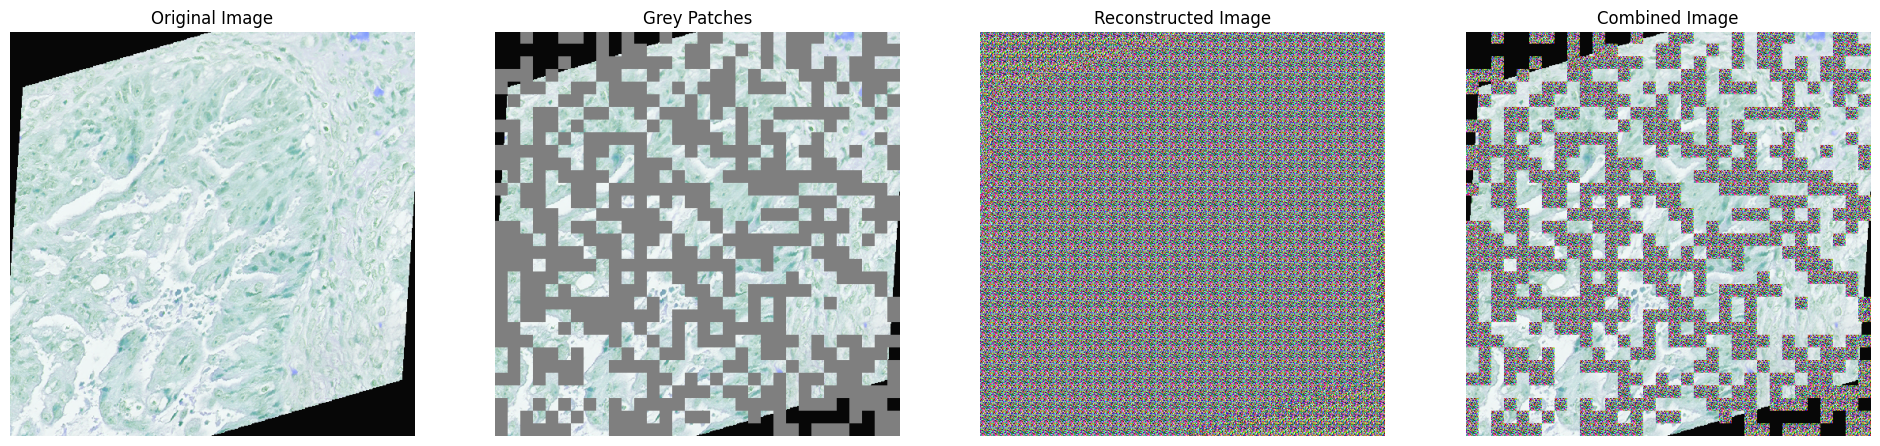

tensor(1.4202)
tensor([False]) tensor([2]) tensor([[ 0.2786, -0.6587, -0.5752,  0.5829,  1.0541]])


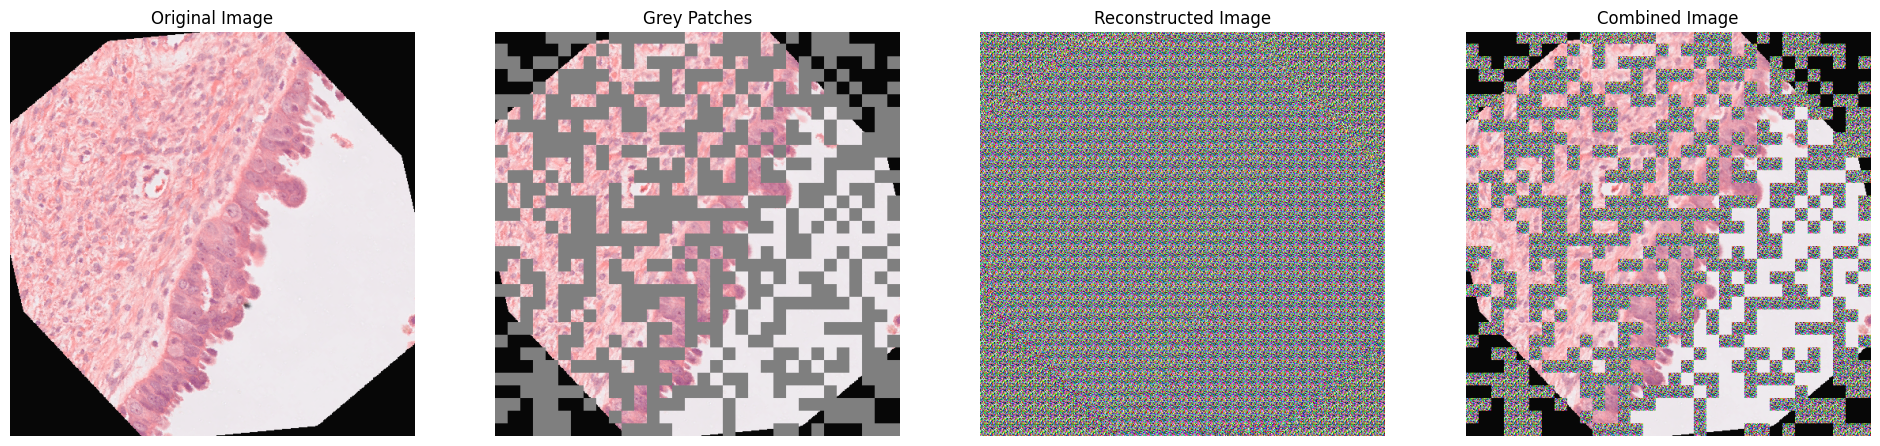

tensor(1.2287)
tensor([False]) tensor([2]) tensor([[ 0.5727, -0.6044, -0.4696,  0.5535,  1.2702]])


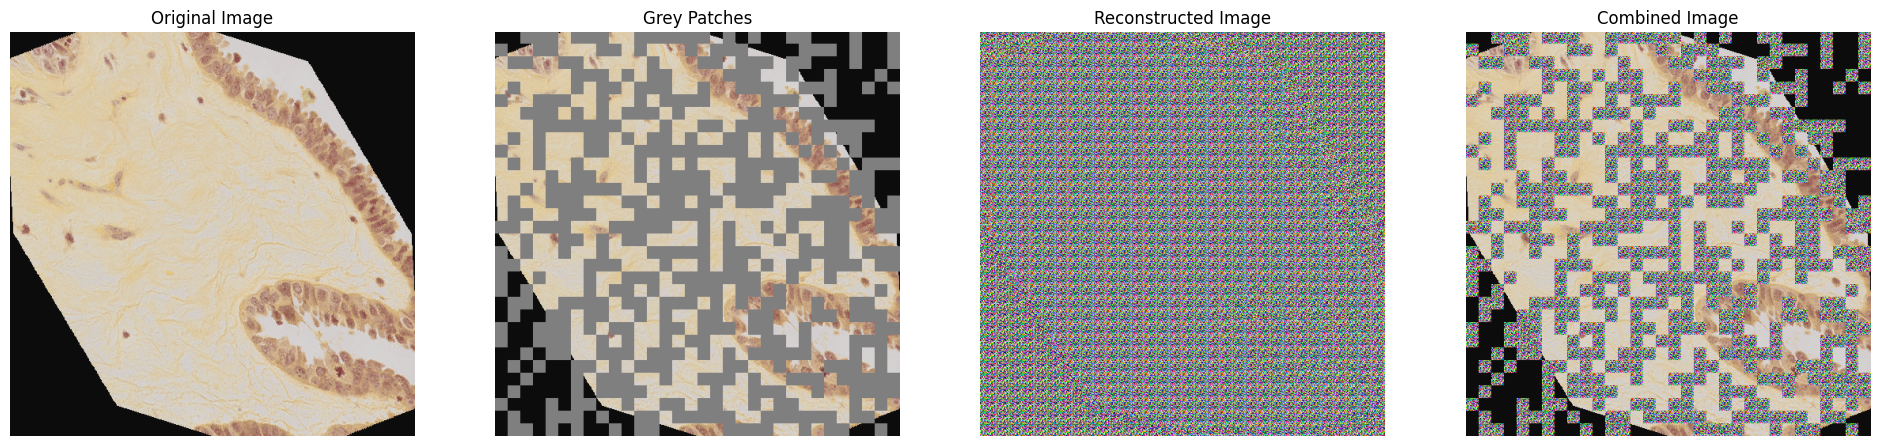


KeyboardInterrupt



In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def fold_back(unfolded, original_height, original_width):
    # Create a tensor to hold the folded back image
    folded = torch.zeros((unfolded.shape[0], unfolded.shape[1], original_height, original_width))

    # Variables to keep track of where to place the blocks
    height_idx = 0
    width_idx = 0

    for i in range(unfolded.shape[2]):
        for j in range(unfolded.shape[3]):
            # Extract the block
            block = unfolded[:, :, i, j, :, :]

            # Place the block in the corresponding position in the folded tensor
            folded[:, :, height_idx:height_idx+16, width_idx:width_idx+16] = block

            # Update the width index, and reset it and update the height index if we reach the end of the row
            width_idx += 16
            if width_idx >= original_width:
                width_idx = 0
                height_idx += 16

    return folded

model.eval()
torch.manual_seed(0)
with torch.no_grad():
    for i, (images, labels, _) in enumerate(train_dataloader, 0):
        images = images.to(device)
        labels = labels.to(device)
        mask = torch.rand((BATCH_SIZE, (IMAGE_SIZE // 16) ** 2)) < 0.5
        mask = mask.to(device)
        # outputs = model(images, mask=mask)
        outputs = model(images, mask=None)
    
        patches = images.unfold(2, 16, 16).unfold(3, 16, 16)
        patches = patches.permute(0, 2, 3, 4, 5, 1).contiguous()
        patches = patches.reshape(BATCH_SIZE, (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16), 16 * 16 * 3)
        
        reconstructed_images = outputs[:, 1:, :]
        # Comment the below line to show the entire (unmasked) output
        # reconstructed_images = torch.where(mask.unsqueeze(-1), reconstructed_images, torch.zeros_like(patches))
        reconstructed_images = reconstructed_images.reshape(BATCH_SIZE, (IMAGE_SIZE // 16), (IMAGE_SIZE // 16), 16, 16, 3)
        reconstructed_images = reconstructed_images.permute(0, 5, 1, 2, 3, 4).contiguous()
        reconstructed_images = fold_back(reconstructed_images, IMAGE_SIZE, IMAGE_SIZE)
        
        # Apply the mask - replace masked patches with the mask token
        blacked_out_images = torch.where(mask.unsqueeze(-1), torch.zeros_like(patches), patches)
        blacked_out_images = blacked_out_images.reshape(BATCH_SIZE, (IMAGE_SIZE // 16), (IMAGE_SIZE // 16), 16, 16, 3)
        blacked_out_images = blacked_out_images.permute(0, 5, 1, 2, 3, 4).contiguous()
        blacked_out_images = fold_back(blacked_out_images, IMAGE_SIZE, IMAGE_SIZE)
        
        combined_images = torch.where(mask.unsqueeze(-1), outputs[:, 1:, :], patches)
        combined_images = combined_images.reshape(BATCH_SIZE, (IMAGE_SIZE // 16), (IMAGE_SIZE // 16), 16, 16, 3)
        combined_images = combined_images.permute(0, 5, 1, 2, 3, 4).contiguous()
        combined_images = fold_back(combined_images, IMAGE_SIZE, IMAGE_SIZE)

        # Converting tensors to numpy for plotting
        original_image_np = images[0].permute(1, 2, 0).detach().cpu().numpy()
        blacked_out_image_np = blacked_out_images[0].permute(1, 2, 0).detach().cpu().numpy()
        reconstructed_image_np = reconstructed_images[0].permute(1, 2, 0).detach().cpu().numpy()
        combined_image_np = combined_images[0].permute(1, 2, 0).detach().cpu().numpy()
        
        logits = classifier_model(images)
        print(F.mse_loss(patches[mask], outputs[:, 1:, :][mask]))
        print(logits.argmax() == labels, labels, classifier_model(images))

        original_image_np = (original_image_np + 1) / 2
        blacked_out_image_np = (blacked_out_image_np + 1) / 2
        reconstructed_image_np = (reconstructed_image_np + 1) / 2
        combined_image_np = (combined_image_np + 1) / 2

        # Add to the existing plotting code
        fig, ax = plt.subplots(1, 4, figsize=(24, 6), dpi=100)
        ax[0].imshow(np.clip(original_image_np, 0, 1))
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        ax[1].imshow(np.clip(blacked_out_image_np, 0, 1))
        ax[1].set_title('Grey Patches')
        ax[1].axis('off')

        ax[2].imshow(np.clip(reconstructed_image_np, 0, 1))
        ax[2].set_title('Reconstructed Image')
        ax[2].axis('off')

        ax[3].imshow(np.clip(combined_image_np, 0, 1))
        ax[3].set_title('Combined Image')
        ax[3].axis('off')

        plt.show()
